In [1]:
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image, plotting
from nilearn.masking import intersect_masks

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.data_io import (
    load_tsv_data,
    resolve_file,
)


In [2]:
def mask_qc(mask_subj, mask_group):
    r"""
    Returns:
      dice: Dice(mask_subj, mask_group)
      missing_frac: fraction of group voxels missing in subject = |G \ S| / |G|
      extra_frac: fraction of subject voxels outside group = |S \ G| / |S|
      (plus some counts for debugging)
    """
    S = image.get_data(mask_subj).astype(bool)
    G = image.get_data(mask_group).astype(bool)

    inter = (S & G).sum()
    s = S.sum()
    g = G.sum()

    dice = np.nan if (s + g) == 0 else (2.0 * inter / (s + g))

    missing = (G & ~S).sum()
    extra = (S & ~G).sum()

    missing_frac = np.nan if g == 0 else (missing / g)
    extra_frac = np.nan if s == 0 else (extra / s)

    return {
        'dice': float(dice),
        'missing_frac': float(missing_frac),
        'extra_frac': float(extra_frac),
        'n_intersection': int(inter),
        'n_subj': int(s),
        'n_group': int(g),
        'n_missing': int(missing),
        'n_extra': int(extra),
    }

In [4]:
cfg = load_config()
good_subs_csv = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_csv)

In [5]:
cfg.data_root

PosixPath('/oak/stanford/groups/russpold/users/buckholtz/DD_Kable')

In [6]:
row = 0
sub_id = good_subs.loc[row, 'sub_id']
run = good_subs.loc[row, 'run']

bold_data = resolve_file(cfg, sub_id, 'scan1', run, 'bold')

In [7]:
mask_output_dir = cfg.masks_dir / 'assess_subject_bold_dropout/nifti_masker_masks'

In [8]:
all_mask_files = glob(str(mask_output_dir / '*.nii.gz'))

In [9]:
aggregate_mask = intersect_masks(all_mask_files, threshold=0.3)

In [10]:
aggregate_mask.to_filename(
    cfg.masks_dir / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)

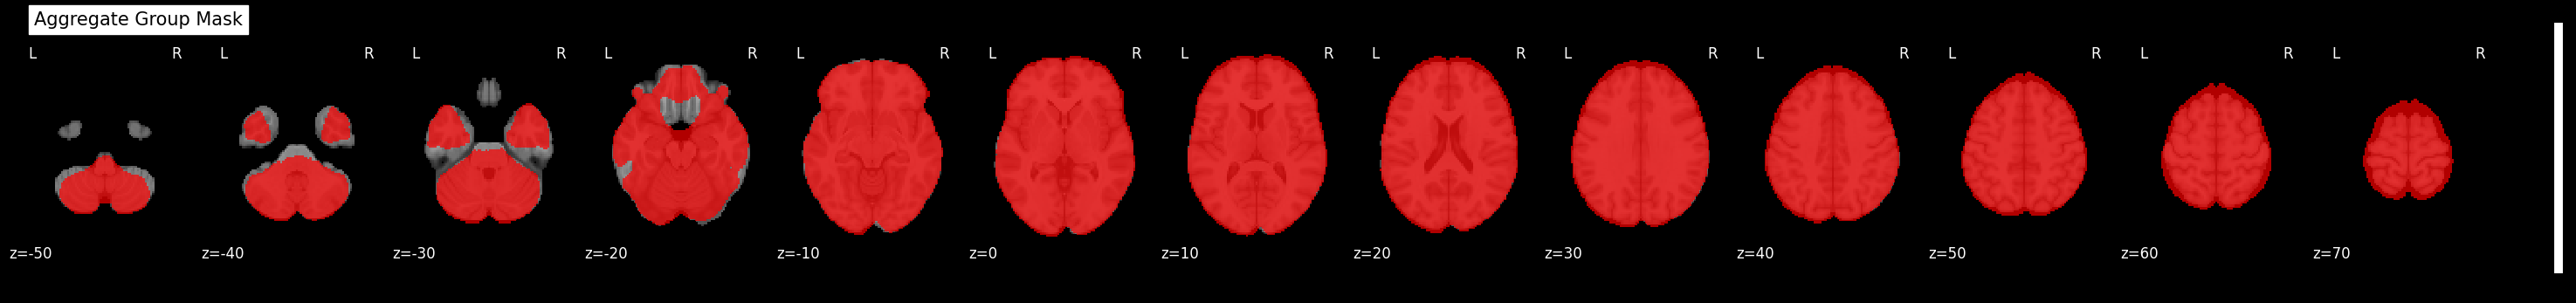

In [11]:
z_slices = np.arange(-50, 71, 10)

plotting.plot_roi(
    aggregate_mask,
    display_mode='z',
    cut_coords=z_slices,
    cmap='autumn',
    black_bg=True,
    title='Aggregate Group Mask',
)
plt.show()

In [12]:
qc_rows = []

for row in good_subs.itertuples(index=False):
    sub_id = row.sub_id
    run = row.run
    mask_path = mask_output_dir / f'sub-{sub_id}_run-{run}.nii.gz'

    if not mask_path.exists():
        print(f'Mask missing for sub={sub_id}, run={run}')
        continue

    # ensure same grid as aggregate_mask (important)
    m = image.load_img(mask_path)

    qc = mask_qc(m, aggregate_mask)  # returns dice, missing_frac, extra_frac, counts
    qc_rows.append({'sub_id': sub_id, 'run': run, 'mask_path': str(mask_path), **qc})

qc_df = pd.DataFrame(qc_rows)

In [13]:
mask_output_dir

PosixPath('/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/masks/assess_subject_bold_dropout/nifti_masker_masks')

In [14]:
# Flag outliers by IQR (more adaptive than fixed missing cutoff)
q1, q3 = qc_df['missing_frac'].quantile([0.25, 0.75])
iqr = q3 - q1
missing_iqr_cutoff = q3 + 1.5 * iqr
baddies_iqr = qc_df[qc_df['missing_frac'] > missing_iqr_cutoff].sort_values(
    'missing_frac', ascending=False
)

print(f'Missing IQR cutoff: {missing_iqr_cutoff:.4f}')
print(f'Baddies (missing IQR rule): {len(baddies_iqr)}')


Missing IQR cutoff: 0.1637
Baddies (missing IQR rule): 14


In [15]:
baddies_iqr

,sub_id,run,mask_path,dice,missing_frac,extra_frac,n_intersection,n_subj,n_group,n_missing,n_extra
114,dmp0305,1,/oak/stanford/groups/russpold/users/buckholtz/...,0.688860,0.474026,0.002109,126309,126576,240143,113834,267
399,dmp1135,1,/oak/stanford/groups/russpold/users/buckholtz/...,0.744160,0.405204,0.006303,142836,143742,240143,97307,906
223,dmp0701,3,/oak/stanford/groups/russpold/users/buckholtz/...,0.756042,0.388439,0.010090,146862,148359,240143,93281,1497
198,dmp0587,4,/oak/stanford/groups/russpold/users/buckholtz/...,0.773102,0.363987,0.014473,152734,154977,240143,87409,2243
416,dmp1225,4,/oak/stanford/groups/russpold/users/buckholtz/...,0.815618,0.307696,0.007617,166252,167528,240143,73891,1276
360,dmp1006,4,/oak/stanford/groups/russpold/users/buckholtz/...,0.850412,0.257634,0.004734,178274,179122,240143,61869,848
280,dmp0844,2,/oak/stanford/groups/russpold/users/buckholtz/...,0.868221,0.228168,0.007879,185350,186822,240143,54793,1472
282,dmp0844,4,/oak/stanford/groups/russpold/users/buckholtz/...,0.871011,0.225149,0.005579,186075,187119,240143,54068,1044
182,dmp0556,2,/oak/stanford/groups/russpold/users/buckholtz/...,0.878373,0.214501,0.003845,188632,189360,240143,51511,728
290,dmp0877,1,/oak/stanford/groups/russpold/users/buckholtz/...,0.883864,0.206256,0.002929,190612,191172,240143,49531,560


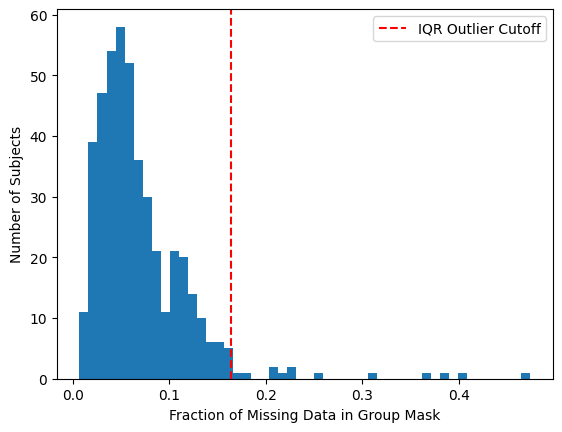

In [16]:
plt.hist(qc_df['missing_frac'], bins=50)
plt.axvline(
    missing_iqr_cutoff, color='red', linestyle='dashed', label='IQR Outlier Cutoff'
)
plt.legend()
plt.xlabel('Fraction of Missing Data in Group Mask')
plt.ylabel('Number of Subjects')
plt.show()

/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


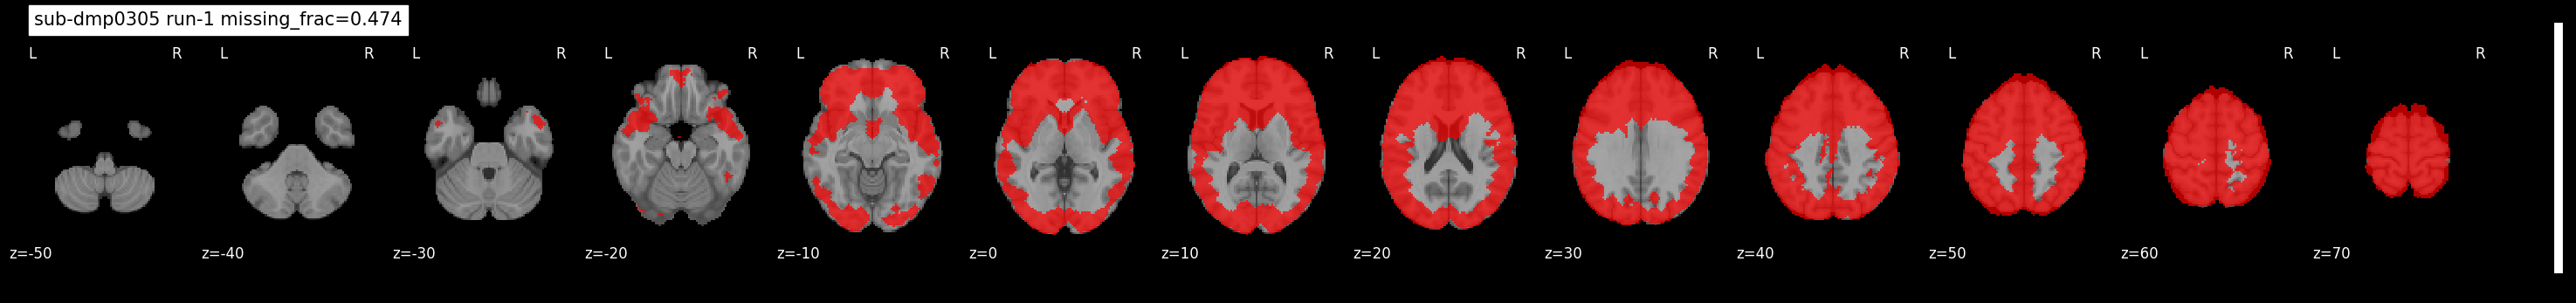

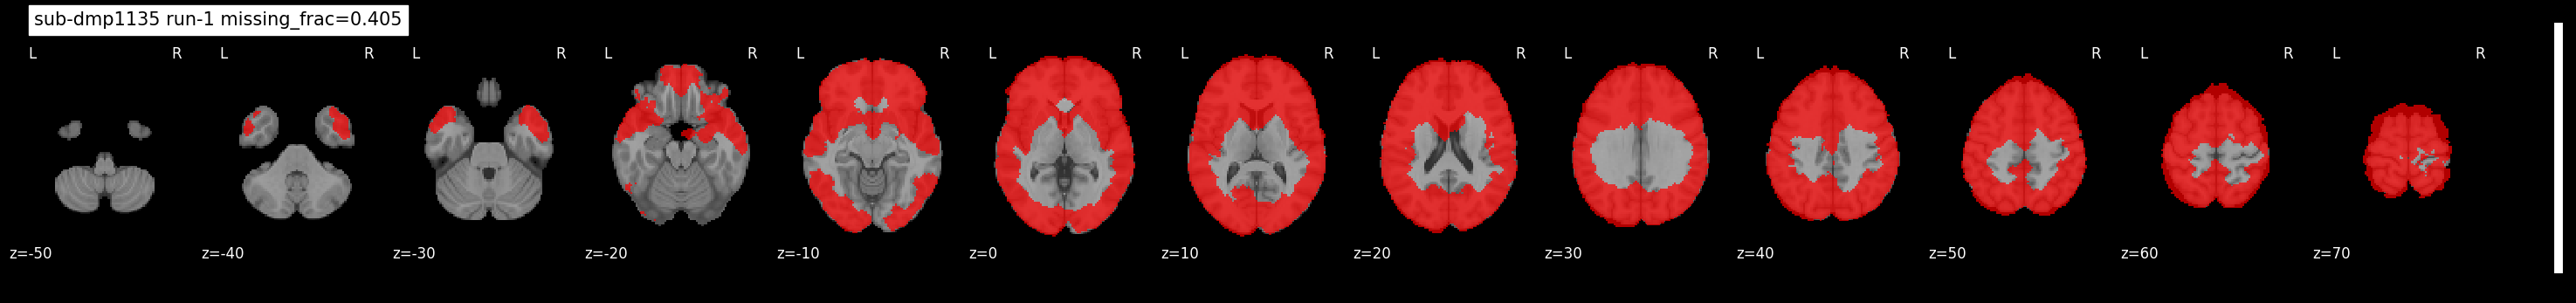

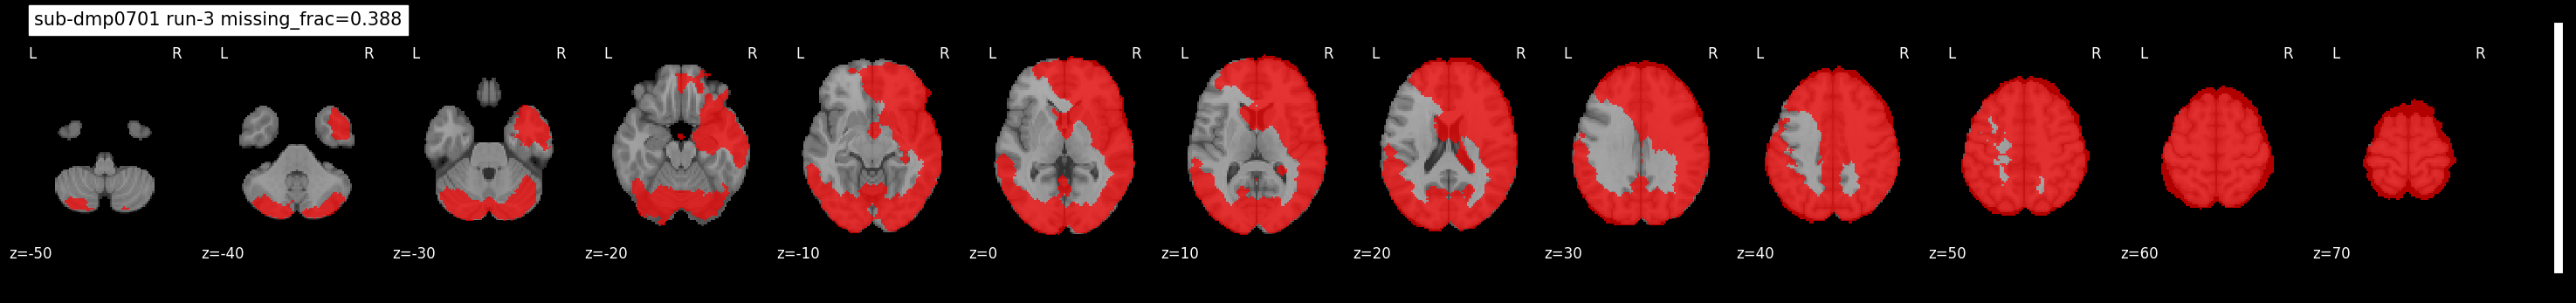

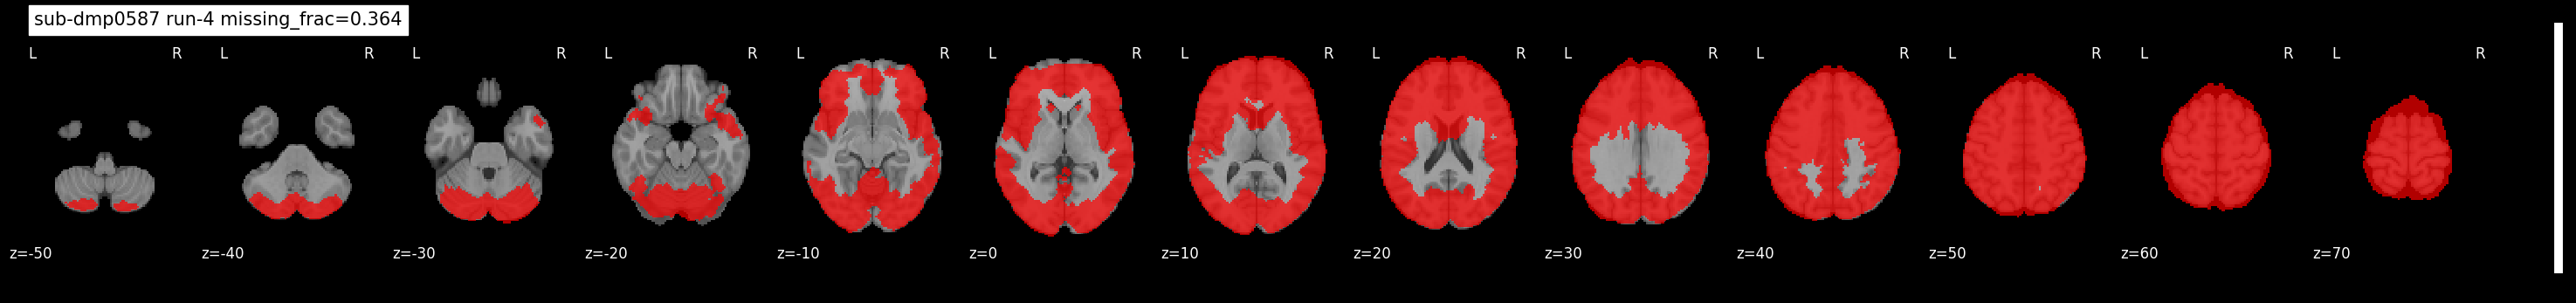

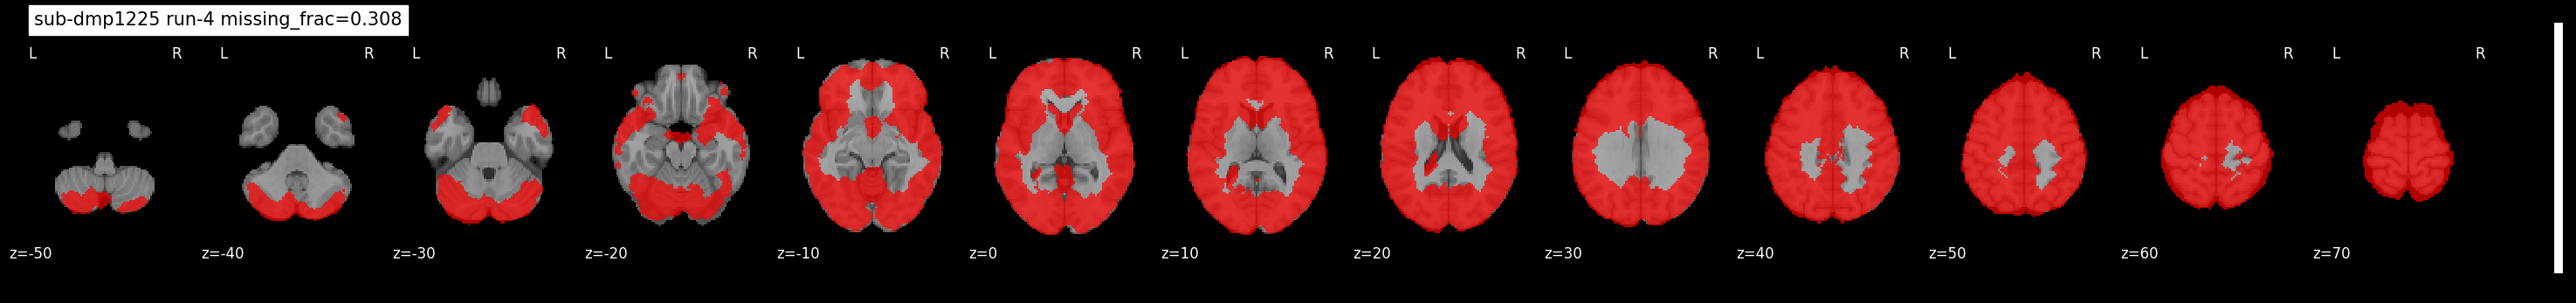

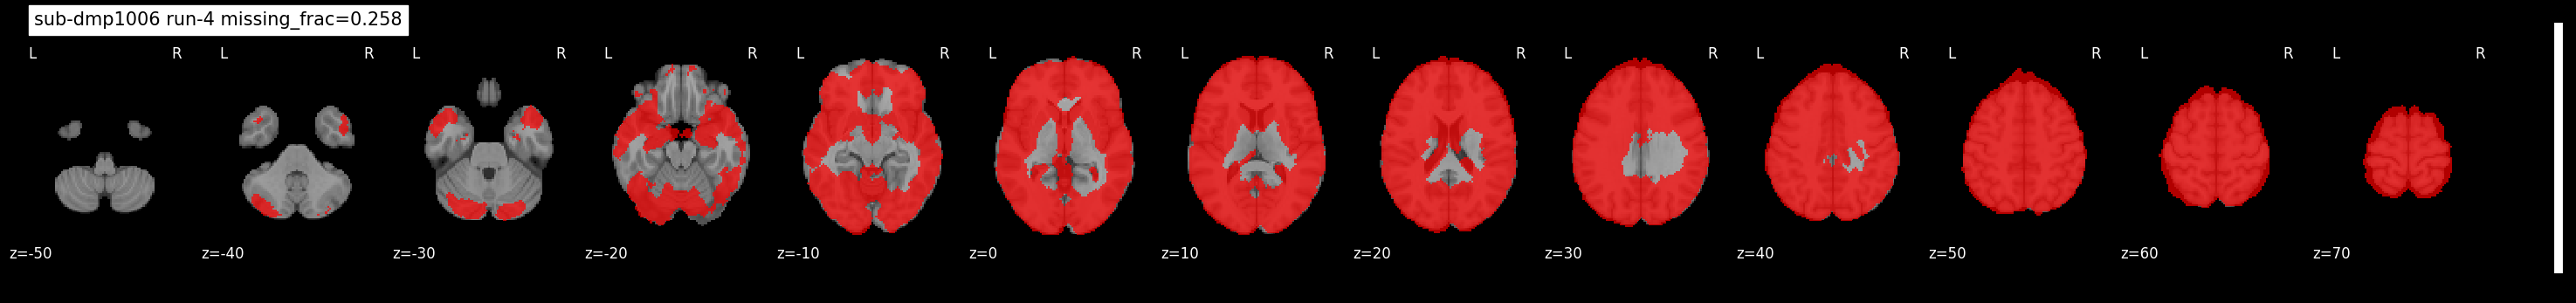

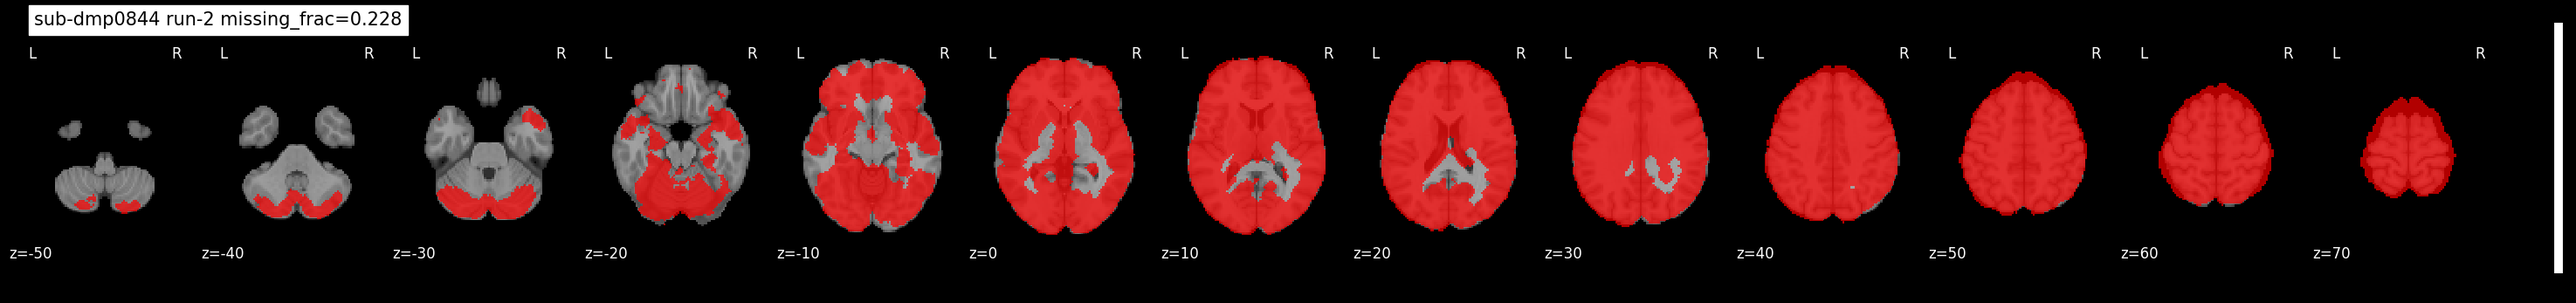

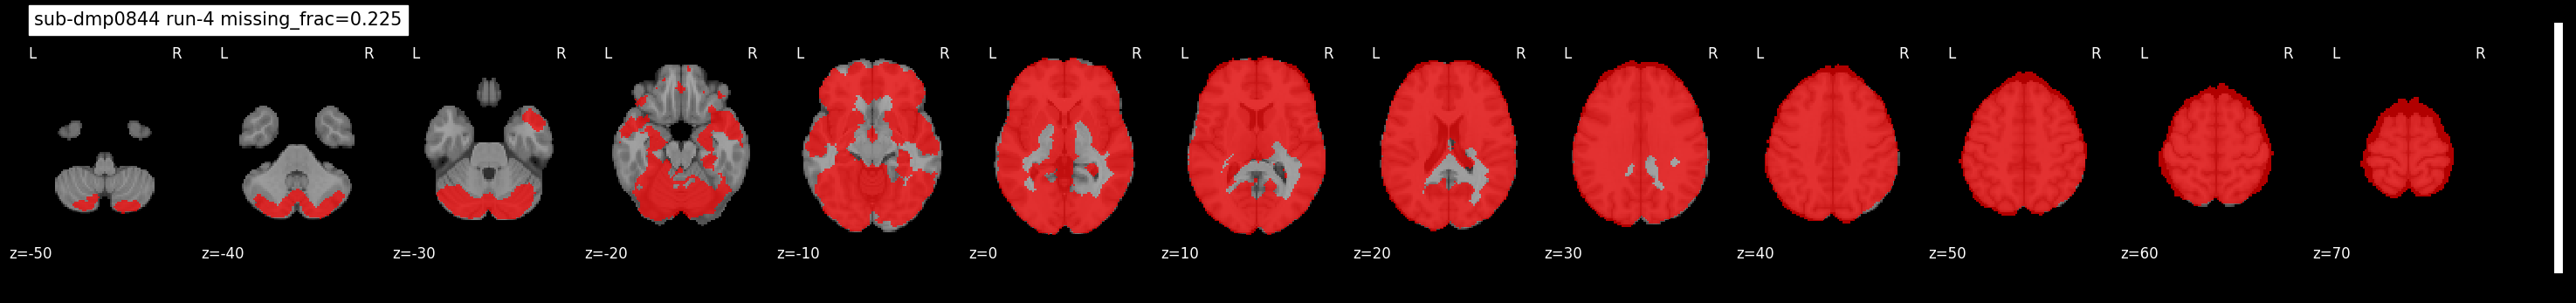

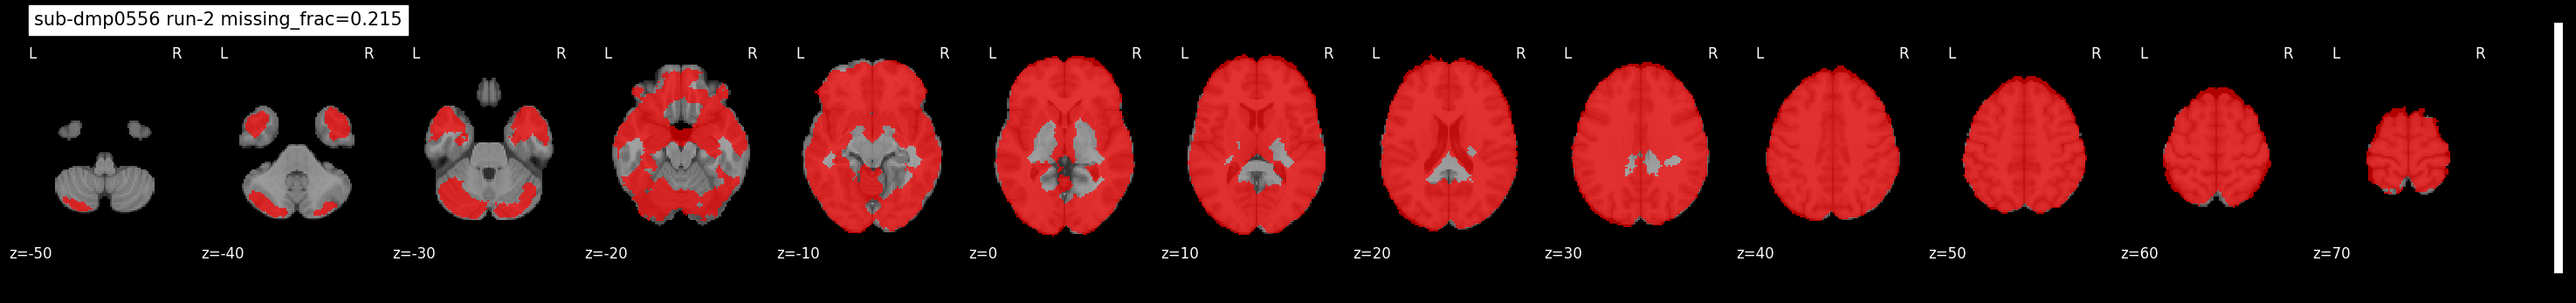

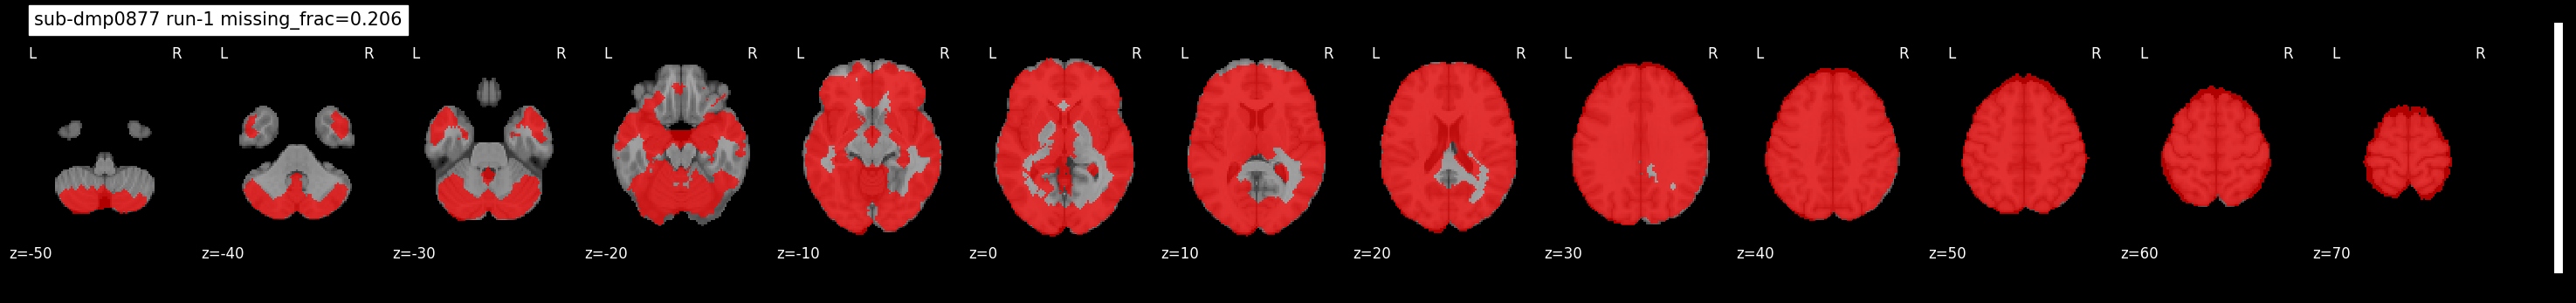

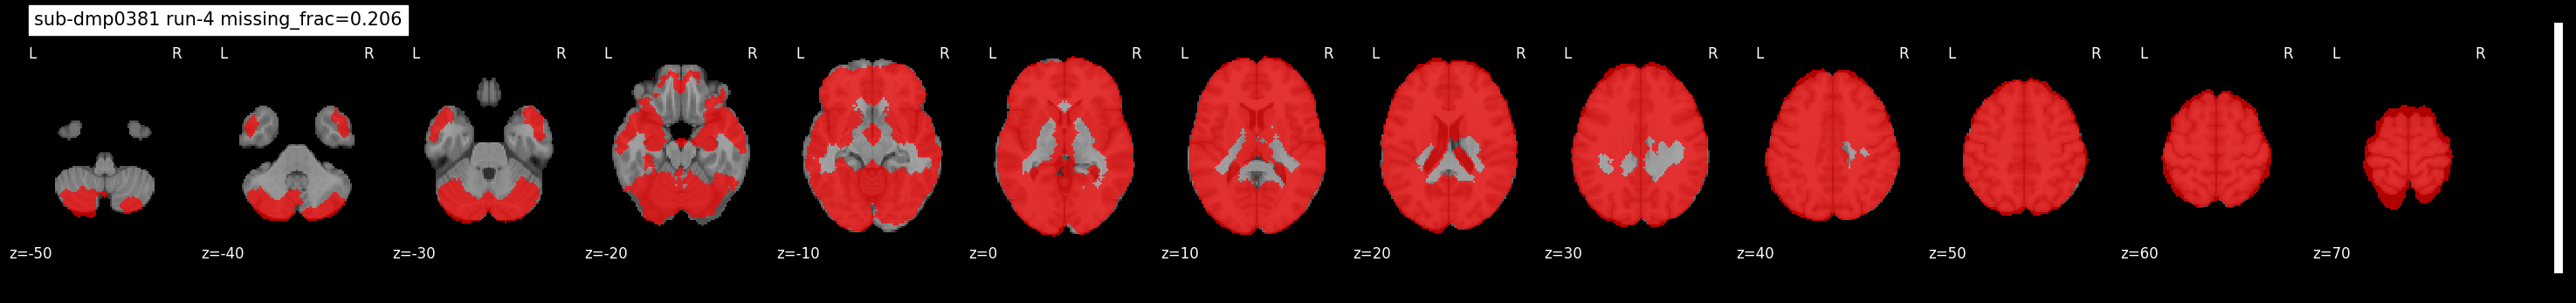

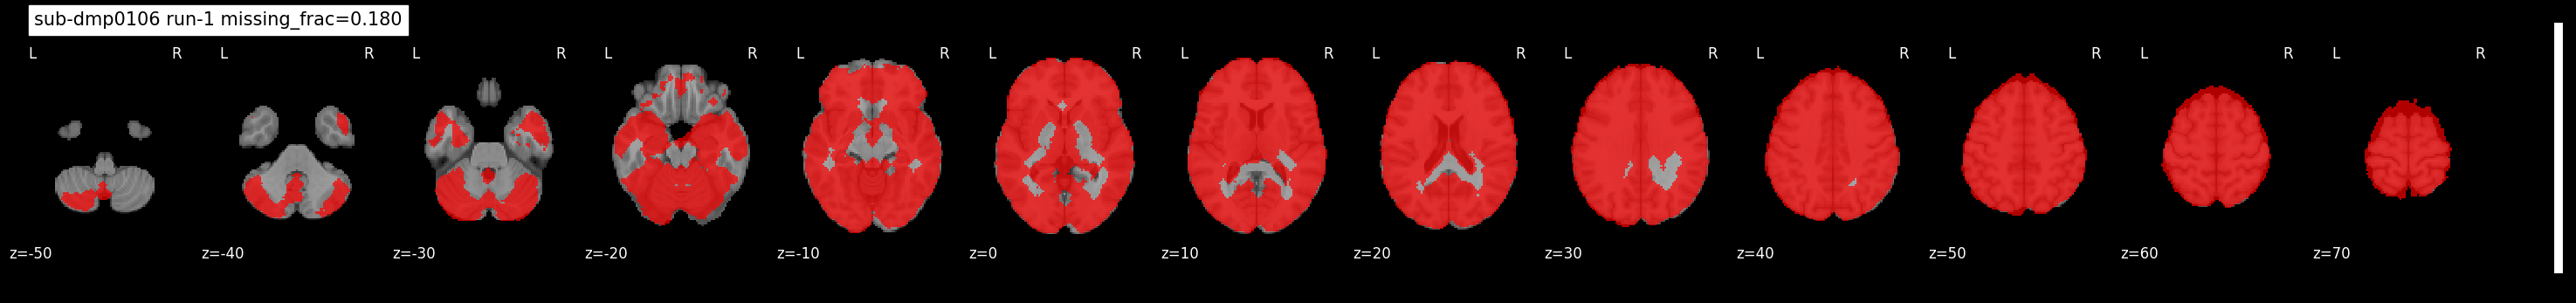

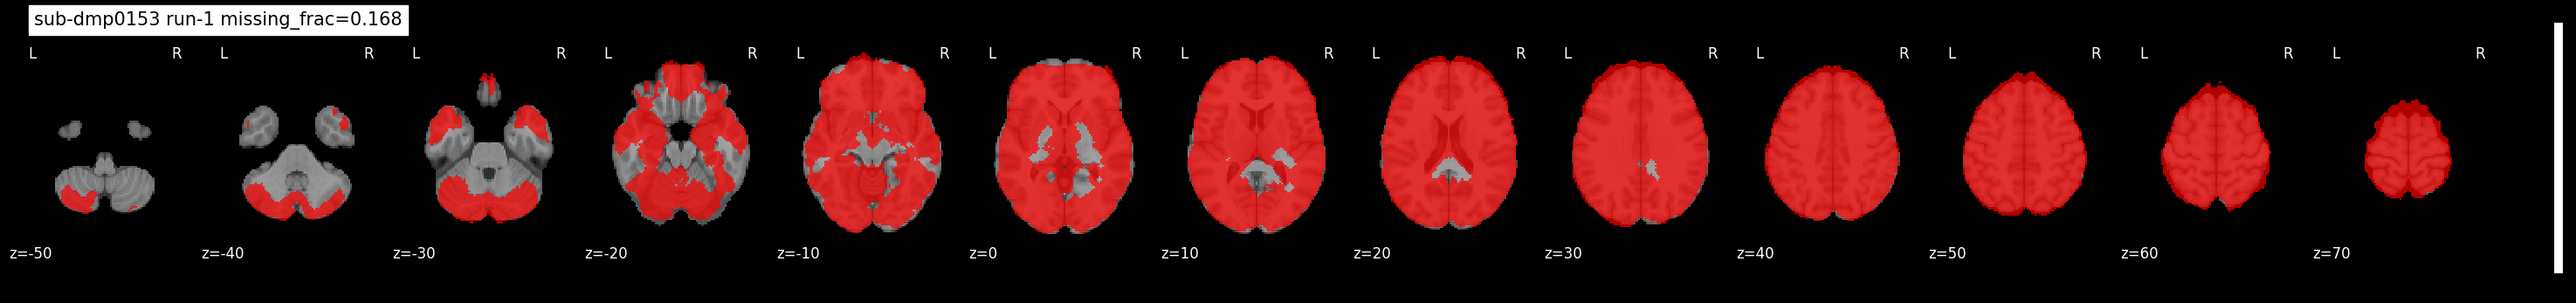

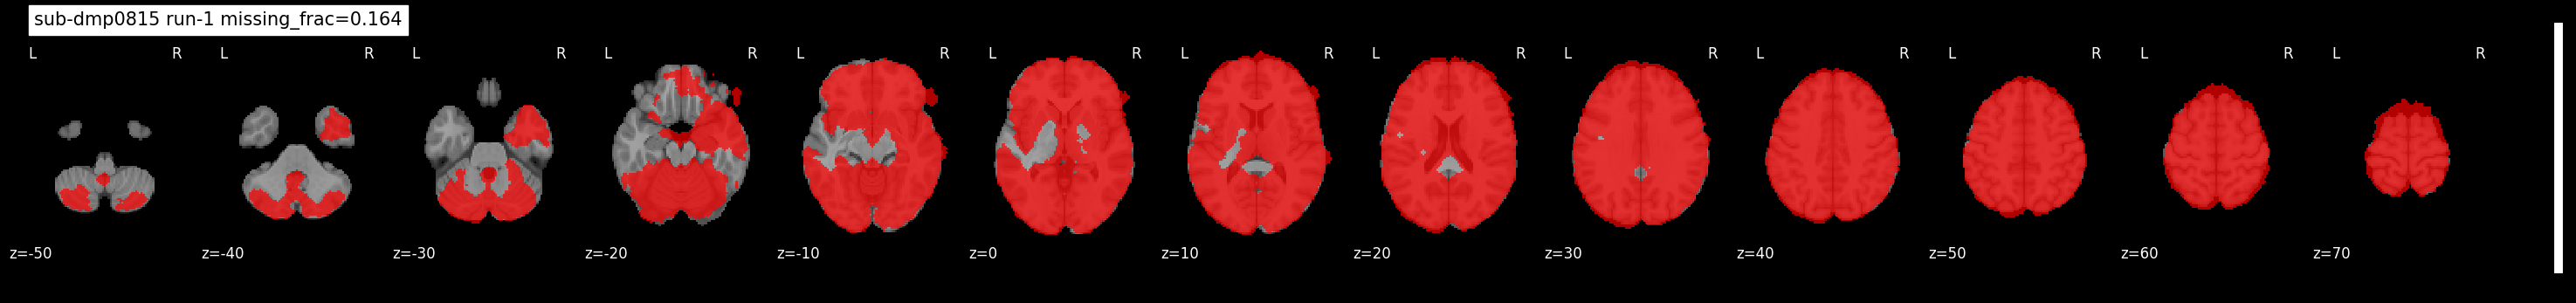

In [17]:
for row in baddies_iqr.itertuples(index=False):
    mask_img = image.load_img(row.mask_path)
    plotting.plot_roi(
        mask_img,
        display_mode='z',
        cut_coords=z_slices,
        cmap='autumn',
        black_bg=True,
        title=f'sub-{row.sub_id} run-{row.run} missing_frac={row.missing_frac:.3f}',
    )
    plt.show()

In [18]:
good_data = qc_df.loc[qc_df['missing_frac'] <= missing_iqr_cutoff, ['sub_id', 'run']]

In [19]:
good_data.insert(1, 'session', 'scan1')
good_data

,sub_id,session,run
0,dmp0011,scan1,1
1,dmp0011,scan1,2
2,dmp0011,scan1,3
3,dmp0011,scan1,4
4,dmp0019,scan1,1
...,...,...,...
449,dmp1271,scan1,4
450,dmp1291,scan1,1
451,dmp1291,scan1,2
452,dmp1291,scan1,3


In [20]:
good_data.to_csv(
    cfg.subject_lists / 'initial_qa_pass_and_mask_pass_subjects_runs.csv', index=False
)

In [21]:
good_data

,sub_id,session,run
0,dmp0011,scan1,1
1,dmp0011,scan1,2
2,dmp0011,scan1,3
3,dmp0011,scan1,4
4,dmp0019,scan1,1
...,...,...,...
449,dmp1271,scan1,4
450,dmp1291,scan1,1
451,dmp1291,scan1,2
452,dmp1291,scan1,3


In [22]:
good_subs

,sub_id,session,run
0,dmp0011,scan1,1
1,dmp0011,scan1,2
2,dmp0011,scan1,3
3,dmp0011,scan1,4
4,dmp0019,scan1,1
...,...,...,...
449,dmp1271,scan1,4
450,dmp1291,scan1,1
451,dmp1291,scan1,2
452,dmp1291,scan1,3
